# Parallel Iterative Methods (in Julia)
### _Utilizing excess processing power_

_Conor Curry_

Parallel processing is the idea of using multiple semi-independent streams of instructions and/or data to achieve a program speedup.

The Julia language has built-in tools to make parallel numerical processing relatively easy.

In this first example, we only have a single process. So, our print should happen once.

In [1]:
@everywhere println("Hello")

Hello


Lets add some processes, to make this parallel.

In [2]:
addprocs(8)
@everywhere println("Hej")

Hej
	From worker 2:	Hej
	From worker 6:	Hej
	From worker 7:	Hej
	From worker 4:	Hej
	From worker 8:	Hej
	From worker 3:	Hej
	From worker 9:	Hej
	From worker 5:	Hej


After we add 8 processes, we have 8 workers, and one master (the calling process). 

Here we've used the `@everywhere` macro to send a function to be evaluated by **every** process (including the master).

## What happens when we work with arrays?

In [3]:
@everywhere println(rand(2,2))

[0.0	From worker 5:	[0.722133 0.475486; 0.261045 0.439297]
508189 0.682605; 0.622404 0.552853]
	From worker 7:	[0.0691057 0.9266; 0.46679 0.449829]
	From worker 3:	[0.13173 0.184641; 0.661123 0.277325]
	From worker 8:	[0.2258 0.518572; 0.655396 0.347718]
	From worker 9:	[0.260516 0.546671; 0.318901 0.594424]
	From worker 6:	[0.80088 0.337003; 0.847599 0.774482]
	From worker 2:	[0.462502 0.53817; 0.715189 0.719102]
	From worker 4:	[0.024076 0.321367; 0.755005 0.485862]


Predictibly, each process made its *own* random numbers.

This is **no good** for parallelizing iterative methods. 

Notice as well that the processes aren't executing in any particular order. 

This is a **major** feature that separates *parallel* programs from *sequential* programs.

## Shared Arrays

Let's initialize a _"Shared Array"_ using the workers, to be shared amongst the workers.

In [4]:
A = SharedArray(Int64, 
                (4,5), 
                init = S::SharedArray -> S[indexpids(S):length(procs(S)):length(S)] = myid())

4×5 SharedArray{Int64,2}:
 2  6  2  6  2
 3  7  3  7  3
 4  8  4  8  4
 5  9  5  9  5

Above, the work of initializing was split evenly among the 8 workers. 

In a **20** element matrix, each processor got either **2 or 3** to initialize (value in the matrix = ID of the assigned worker). 

The `indexpids` function was used to set the start index 
(values 1-8 depending on the processor), 
and the rest of the range sets the _stride_.

In [7]:
for p in procs(A)
    @async println(fetch(remotecall_wait(indexpids, p, A)))
end

## Sequential Jacobi

In [8]:
function jacobi(N, x0, xf, g0, gf, f, itermax)
    h = (xf-x0) / (N+1)
    u = [f(i*h) for i in 0:(N+1)]
    u[1] = g0
    u[end] = gf
    unew = zeros(Float64, size(u))
    res = zeros(Float64, size(u))
    Δ = zeros(Float64, size(u))
    b = zeros(Float64, size(u))
    
    for iter in 1:itermax
        for i in 2:N+1
            au = u[i-1] + u[i+1]
            b[i] = f((i-1)*h) * (h^2)
            unew[i] = 1/2 * (b[i] + au)
            res[i] = b[i] + au - (2u[i])
            Δ[i] = unew[i] - u[i] 
        end        
        #swap references to avoid copying data/busying garbage collector
        u, unew = unew, u 
    end
    return u
end

jacobi (generic function with 1 method)

# Parallel Jacobi

_The Method of Simultaneous Displacements_

To parallelize Jacobi, we just need to make the displacements as "simultaneous" as possible.

So just try to divide up the work among the workers as evenly as possible.

In [9]:
@everywhere function jacobi_inner_shared!(u, unew, res, Δ, b, f, h, myrange)
    for i in myrange
        au = u[i-1] + u[i+1]
        b[i] = f((i-1)*h) * (h^2)
        unew[i] = 1/2 * (b[i] + au)
        res[i] = b[i] + au - (2u[i])
        Δ[i] = unew[i] - u[i]
    end
end;

7
8
1
3
6
2
5
4


This little code shard is the meat of the Jacobi method, and is what the indivdual workers will do.

In [10]:
@everywhere function get_chunk(S::SharedArray)
    idx = indexpids(S)
    if idx == 0
        return 1:0
    end    
    splits = [round(Int, s) for s in linspace(1,length(S)-1,length(procs(S))+1)]
    return splits[idx]+1:splits[idx+1]    
end;

This just splits up the work evenly...

In [11]:
@everywhere function jacobi_inner_chunk!(u, unew, res, Δ, b, f, h)
    jacobi_inner_shared!(u, unew, res, Δ, b, f, h, get_chunk(u))
end

And this is a helpful little function for allocating the right partition to the right worker.

In [12]:
function parallel_jacobi(N, x0, xf, g0, gf, f, itermax)
    h = (xf-x0) / (N+1)
    u = convert(SharedArray, [f(i*h) for i in 0:(N+1)])
    u[1] = g0
    u[end] = gf
    unew = SharedArray(Float64, size(u))
    res = SharedArray(Float64, size(u))
    Δ = SharedArray(Float64, size(u))
    b = SharedArray(Float64, size(u))
    
    for iter in 1:itermax
        @sync begin
            for p in procs(u)
                @async remotecall_wait(jacobi_inner_chunk!, p, u, unew, res, Δ, b, f, h)
            end
        end
        #swap references to avoid copying data/busying garbage collector
        u, unew = unew, u 
    end
    return u
end;

Here all of the arrays are `SharedArray`s, and the processes are asynchronously working on tasks.

Before moving on to the next iteration, all the processes need to sync up. This is the job of the `@sync` macro.

In [13]:
#use the function to get it JIT ready for testing
test(1000,250);

10000002-element SharedArray{Float64,1}:
 0.0        
 5.0e-10    
 1.0e-9     
 1.5e-9     
 2.0e-9     
 2.5e-9     
 3.0e-9     
 3.5e-9     
 4.0e-9     
 4.5e-9     
 5.0e-9     
 5.5e-9     
 6.0e-9     
 ⋮          
 0.00188595 
 0.00172456 
 0.00156318 
 0.00139589 
 0.0012286  
 0.00105657 
 0.000884543
 0.000709045
 0.000533547
 0.000355935
 0.000178323
 0.0        

# Results

Tested with the following function

In [14]:
function test(N, maxits)
    x0=0
    xf=1
    g0=gf=0

    println("Serial Jacobi: ")
    @time u = jacobi(N, x0, xf, g0, gf, (x)->x/200, maxits)
    println("\n Parallel Jacobi: ")
    @time pu = parallel_jacobi(N, x0, xf, g0, gf, (x)->x/200, maxits)

    println("\nu == pu : $(u==pu)")
end;

In [15]:
test(10000000, 500);

Serial Jacobi: 
 87.657118 seconds (17 allocations: 381.471 MB, 0.23% gc time)

 Parallel Jacobi: 
 46.852401 seconds (1.93 M allocations: 171.581 MB, 0.44% gc time)

u == pu : true


With a **one dimensional** mesh of N=**10M** 64-bit floating point numbers, and **500** iterations, _parallelized Jacobi comes out on top_, nearly _doubling_ the speed of the serial implementation.

Just to show that it was using all of my CPU cores...

## Serial Jacobi CPU Usage
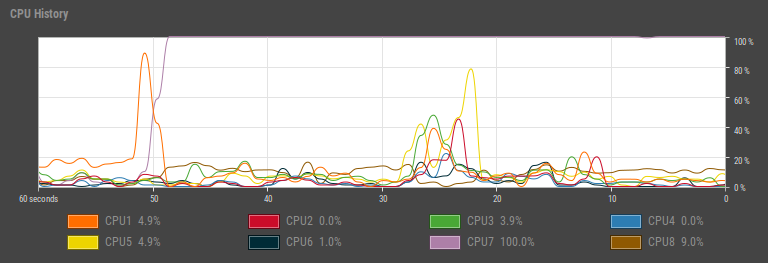

## Parallel Jacobi CPU Usage
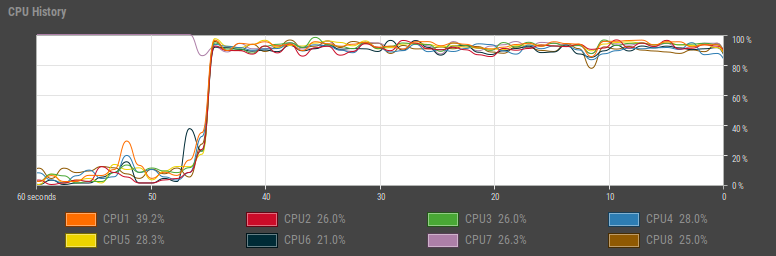

Now, the variables here are the mesh-points and the number of iterations.

The way Jacobi was implemented here is good at performing well on _finer meshes_

**However, the speedup is not really significant if you just want more iterations.**

### With 1M points, 250 iterations...

In [16]:
test(1000000,250);

Serial Jacobi: 
  3.968351 seconds (1.87 k allocations: 38.244 MB, 0.22% gc time)

 Parallel Jacobi: 
  3.093878 seconds (876.25 k allocations: 51.540 MB, 0.48% gc time)

u == pu : true


### 500 iterations...

In [17]:
test(1000000,500);

Serial Jacobi: 
  7.879829 seconds (2.13 k allocations: 38.257 MB, 0.24% gc time)

 Parallel Jacobi: 
  5.905537 seconds (1.75 M allocations: 95.367 MB, 0.40% gc time)

u == pu : true


### 1k iterations

In [18]:
test(1000000,1000);

Serial Jacobi: 
 16.281215 seconds (2.15 k allocations: 38.258 MB, 0.03% gc time)

 Parallel Jacobi: 
 11.773927 seconds (3.51 M allocations: 183.025 MB, 0.39% gc time)

u == pu : true


## Whereas while increasing the mesh granularity...

### From 10k...

In [19]:
test(10000,250);

Serial Jacobi: 
  0.037244 seconds (10 allocations: 391.328 KB)

 Parallel Jacobi: 
  0.568166 seconds (882.54 k allocations: 44.161 MB, 1.46% gc time)

u == pu : true


### To 100k...

In [20]:
test(100000,250);

Serial Jacobi: 
  0.399087 seconds (10 allocations: 3.815 MB)

 Parallel Jacobi: 
  0.807935 seconds (881.37 k allocations: 44.839 MB, 2.11% gc time)

u == pu : true


### To 1M

In [21]:
test(1000000,250);

Serial Jacobi: 
  3.869954 seconds (3.94 k allocations: 38.352 MB, 0.16% gc time)

 Parallel Jacobi: 
  3.097642 seconds (867.61 k allocations: 51.276 MB, 1.29% gc time)

u == pu : true


Leads to massive increases in performance compared to the serialized version.

# Other Methods?
_Chaotic Iterative Methods_

Gauss-Siedel and SOR are not able to be parallelized like this, because they **immediately** use the updated values in the next iteration.

So, while G-S and SOR are generally favored over Jacobi, with parallel hardware Jacobi can often be a valid choice.

However, it should be possible to take _whichever updates are available at the time of calculation_ in a parallel method of G-S or SOR. This would not lend itself well to theoretical analysis...

But could yield practical benefit, like was seen with Jacobi.

# References

https://docs.julialang.org/en/latest/manual/parallel-computing

https://docs.julialang.org/en/latest/stdlib/parallel.html

Bru R, Elsner L, Neumann M. Models of parallel chaotic iteration methods. Linear algebra and its applications. 1988;103:175-192.